## Classify spam vs no spam emails


In [6]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

### Import the dataset

In [7]:
df= pd.read_csv("spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df['Category'].value_counts()


ham     4825
spam     747
Name: Category, dtype: int64

In [9]:
df_spam = df[df['Category']=='spam']
df_spam.shape


(747, 2)

In [10]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [11]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [12]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [13]:
df_balanced['Category'].value_counts()


ham     747
spam    747
Name: Category, dtype: int64

In [14]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
2980,spam,"Xmas Offer! Latest Motorola, SonyEricsson & No...",1
3090,ham,What Today-sunday..sunday is holiday..so no wo...,0
3819,spam,74355 XMAS iscoming & ur awarded either £500 C...,1
3735,ham,"4 tacos + 1 rajas burrito, right?",0
2987,spam,Reply to win £100 weekly! What professional sp...,1


### Split it into training and test data set


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

### import BERT model and get embeding vectors for few sample statements

In [18]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [19]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.5132728 , -0.8884573 , ..., -0.74748874,
        -0.7531474 ,  0.91964495],
       [-0.87208354, -0.50543964, -0.9444667 , ..., -0.858475  ,
        -0.7174534 ,  0.88082975]], dtype=float32)>

### sample embeding vectors and compare them using cosine similarity


In [20]:
e = get_sentence_embeding([
    "newyork"
    "banana", 
    "grapes",
    "plane"
    "mango",
    "jeff bezos",
    "rich"
    "elon musk",
    "bill gates"
]
)

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9458072]], dtype=float32)

In [22]:
cosine_similarity([e[0]],[e[3]])


array([[0.9488977]], dtype=float32)

In [23]:
cosine_similarity([e[3]],[e[4]])


array([[0.966786]], dtype=float32)

### Model

In [24]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [25]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [26]:
len(X_train)


1120

In [27]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

### Training the model


In [28]:
model.fit(X_train, y_train, epochs=5)


Epoch 1/5
35/35 [==============================] - 427s 12s/step - loss: 0.6649 - accuracy: 0.5893 - precision: 0.5984 - recall: 0.5429
Epoch 2/5
35/35 [==============================] - 479s 14s/step - loss: 0.5280 - accuracy: 0.7821 - precision: 0.7540 - recall: 0.8375
Epoch 3/5
35/35 [==============================] - 425s 12s/step - loss: 0.4572 - accuracy: 0.8357 - precision: 0.8123 - recall: 0.8732
Epoch 4/5
35/35 [==============================] - 391s 11s/step - loss: 0.4143 - accuracy: 0.8589 - precision: 0.8418 - recall: 0.8839
Epoch 5/5
35/35 [==============================] - 374s 11s/step - loss: 0.3835 - accuracy: 0.8795 - precision: 0.8620 - recall: 0.9036


In [29]:
model.evaluate(X_test, y_test)


12/12 [==============================] - 136s 11s/step - loss: 0.3521 - accuracy: 0.9011 - precision: 0.8750 - recall: 0.9358


[0.35207831859588623, 0.9010695219039917, 0.875, 0.9358288645744324]

In [30]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()


In [31]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[162,  25],
       [ 12, 175]], dtype=int64)

Text(33.0, 0.5, 'Truth')

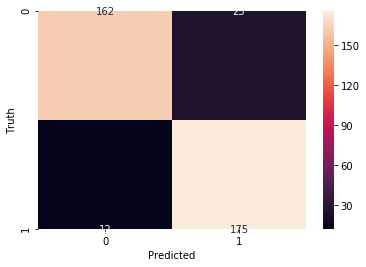

In [35]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [34]:
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.93      0.87      0.90       187
           1       0.88      0.94      0.90       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374

